In [1]:



import os

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import h2pc
import hpc
import pandas as pd

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches




NameError: name 'FlowLayout' is not defined

## Compute data and use an already known structure


In [3]:
true_bn=gum.loadBN("alarm.bif")
gnb.showBN(true_bn,size="20")

In [4]:
#generate database of alarm
gum.generateCSV(true_bn,"test.csv",10000,True)

 test.csv : [ ################################################################ ] 100%
Log2-Likelihood : -150844.12598468218


-150844.12598468218

## Test independance tests (R, PyAgrum and personnal version) on Asia network


In [2]:
from independances import indepandance
asia_bn=gum.loadBN(os.path.join("true_graphes_structures","asia.bif"))

lindep=[("asia","smoke",['lung']),    ("asia","smoke",[]),
                                      ("dysp","smoke",[]),
                                      ("dysp","smoke",["lung","bronc"]),
                                      ("tub","bronc",[]),
                                      ("tub","bronc",["dysp"])]

In [17]:
def compute_independance_tests(bn,sizes,test,nb_test=20,**dico_independance):
    """
    Using $nb_test$ database of size $size$ from the bn $bn$, 
    computing the p-value for a list $lindep$ of conditional independence tests, using $test$ type.
    """
    #pvalue vector stores pvalues for a given size for several conditions
    pvalue_vector=[]
    
    #pvalue amplitude stores the shift between max and min pvalue measured
    pvalue_amplitude=[]
    
    for size in sizes:   
        gum.generateCSV(bn,os.path.join("databases","sample_score.csv"),size,False)
        #learner=gum.BNLearner(os.path.join("databases","sample_score.csv"))
        df=pd.read_csv(os.path.join("databases","sample_score.csv"))
        pvalue_temp=np.empty(nb_test)
        for indice in range(nb_test):
            pvalue_temp[indice]=indepandance(df,*test,**dico_independance).realize_test()[1]
        pvalue_vector.append(np.mean(pvalue_temp))
        pvalue_amplitude.append(np.max(pvalue_temp)-np.min(pvalue_temp))
    return pvalue_vector,pvalue_amplitude







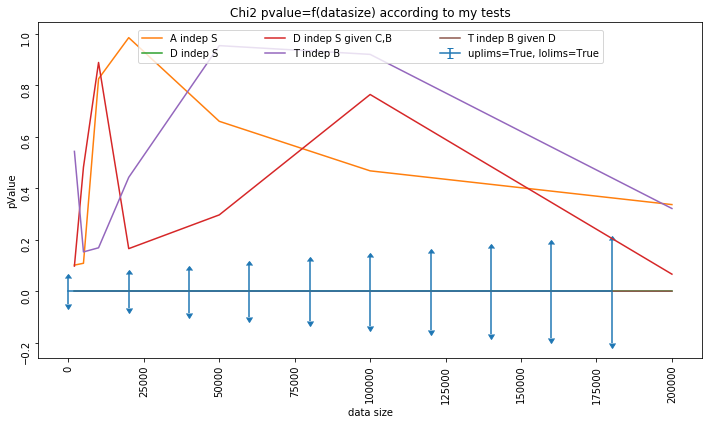

In [10]:
def plot_independance_tests(bn,sizes,lindep,nb_test=20,**dico_independance):

    fig = plt.figure()
    for test in lindep:
        pvalues,pvalues_err=compute_independance_tests(bn,sizes,test,nb_test,**dico_independance)
        plt.errorbar(sizes, pvalues, yerr=pvalues_err, uplims=True, lolims=True, label=format_test(test))
    ax.tick_params(rotation=90)
    ax.set_xlabel("data size")
    ax.set_ylabel("pValue")
    ax.legend(bbox_to_anchor=(0.15, 0.88, 0.7, .102), loc=3,ncol=3, mode="expand", borderaxespad=0.)
    ax.set_title("{} test using {} technique".format(dico_independance.get(calculation_method,"pearson"), \
                                                     dico_independance.get(dof_adjustment,"classic")))
    fig.tight_layout()

def format_test(test):
    if test[2]:
        return ("{} indep {} given {}.".format(*test))
    else:
        return ("{} indep {}.".format(*test[0:2]))
gnb.showBN(asia_bn,size="20")


In [18]:
sizes=[2000,5000,10000,20000,50000,100000,200000]
pvalues1,pvalues2,pvalues3,pvalues4,pvalues5,pvalues6=zip(*[compute_independance_tests(asia_bn,siz,lindep,calculation_method="pearson",dof_adjustment="classic" )
                                      for siz in sizes])



ValueError: not enough values to unpack (expected 6, got 2)

## Use HPC to compute the local set of parents and children
Here, using HPC, we determine the set of parents and children (undirected) of the variable VENTALV.

In [38]:
learner=gum.BNLearner("test.csv") 
couverture_markov_variable=hpc.hpc('CATECHOL',learner,verbosity=False).couverture_markov()
print(couverture_markov_variable)

{'TPR', 'HR', 'EXPCO2', 'ARTCO2', 'VENTALV'}


## Use H2PC to compute global neighbourhood



In [39]:
bn_h2pc=h2pc.H2PC(learner,score_algorithm='3off2').learnBN()
pp.pprint(bn_h2pc.consistent_neighbourhood,width=1)

{(5, 9), (8, 23), (0, 20), (22, 13), (17, 29), (34, 21), (22, 26), (11, 35), (1, 17), (6, 21), (28, 22), (22, 9), (23, 32), (25, 1), (31, 1), (0, 32), (4, 19), (36, 8), (21, 1), (16, 3), (25, 19), (28, 9), (23, 2), (23, 35), (36, 12), (16, 15), (28, 27), (5, 22), (19, 10), (25, 29), (31, 29), (21, 33), (15, 10), (25, 7), (23, 20), (29, 33), (20, 32), (7, 31), (36, 24), (2, 24), (29, 15), (21, 25), (25, 17), (9, 2), (25, 33), (34, 14), (7, 8), (18, 33)}


AttributeError: module 'pprint' has no attribute 'print'

## Compare Learning algorithms
Here, we are going to compare the H2PC hybrid-bases algorithm, with some scoring algorithms already implemented in PyAgrum. First, we do that graphically, then we will use scoring functions. 

In [ ]:
#learner.useMIIC()
#bn_miic=learner.learnBN()

#learner.useGreedyHillClimbing()
#bn_greedy=learner.learnBN()

learner.use3off2()
bn_3off2=learner.learnBN()

learner.useLocalSearchWithTabuList()
bn_tabulist=learner.learnBN()



gnb.sideBySide(gnb.getBNDiff(bn_3off2,true_bn),gnb.getBNDiff(bn_tabulist,true_bn),gnb.getBNDiff(bn_h2pc,true_bn),
               captions=["BN  from 3off2",
                        "BN from TabuList",
                        "BN from H2PC"])


In [14]:
learner=gum.BNLearner("test.csv") 
learner.use3off2()
learner.addPossibleEdge('SHUNT','SAO2')
learner.addPossibleEdge('TPR','BP')
learner.addPossibleEdge('CO','BP')
learner.addPossibleEdge('TPR','DISCONNECT')
learner.addPossibleEdge('TPR','INSUFFANESTH')
learner.addPossibleEdge('CATECHOL','HR')
bn_3off2_constrained=learner.learnBN()
gnb.showBN(bn_3off2_constrained,size=7)

In [9]:
learner=gum.BNLearner("test.csv") 
learner.use3off2()
bn_3off2=learner.learnBN()
gnb.showBN(bn_3off2,size=10)

In [12]:
gnb.sideBySide(gnb.getBNDiff(bn_3off2,bn_3off2_constrained))